In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from google.colab import files

# 1. העלאת קובץ CSV
uploaded = files.upload()  # בחר קובץ להעלות
file_name = list(uploaded.keys())[0]  # קבלת שם הקובץ
df = pd.read_csv(file_name)  # קריאת הקובץ לתוך DataFrame

# 2. חלוקה לקטגוריות (מספרי קטגוריות)
df['category'] = df['category'].astype('category')
category_mapping = dict(enumerate(df['category'].cat.categories))
print("Category Mapping:", category_mapping)  # הדפסת המיפוי בין המספרים לקטגוריות
df['category'] = df['category'].cat.codes

# 3. חלוקה לסטים של אימון והערכה
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['category'].tolist(),
    test_size=0.2
)

# 4. טעינת המילון של BERT (Tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 5. המרת הטקסטים לפורמט שמתאים ל-BERT (Tokenization)
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512)
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=512)

# 6. יצירת מחלקת Dataset
train_dataset = Dataset.from_dict(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict(
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})

# 7. יצירת המודל (מודל סיווג טקסטים מבית BERT)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                      num_labels=len(category_mapping))

# 8. הגדרת פרמטרי האימון
training_args = TrainingArguments(
    output_dir='./results',  # מקום לשמירת תוצאות
    evaluation_strategy="epoch",  # הערכה אחרי כל אפוך
    learning_rate=2e-5,  # קצב הלמידה
    per_device_train_batch_size=8,  # גודל המיני-באטצ'ים באימון
    per_device_eval_batch_size=8,  # גודל המיני-באטצ'ים בהערכה
    num_train_epochs=3,  # מספר האפוכים
    weight_decay=0.01,  # ירידת משקל
)

# 9. יצירת אובייקט Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 10. התחלת האימון
trainer.train()

# 11. שמירת המודל וה-Tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

# 12. שמירת המיפוי בין מספרים לקטגוריות
import json
with open('./saved_model/category_mapping.json', 'w') as f:
    json.dump(category_mapping, f)


Saving learningFile.csv to learningFile (1).csv
Category Mapping: {0: 'השכלה', 1: 'פיננסי', 2: 'רפואה', 3: 'תחבורה'}


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: finalprojectfc (finalprojectfc-finalprojectfc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.549290
2,No log,0.519460
3,No log,0.482701


שימוש במטריצות בלבול על מנת לראות את דיוק המודל

Confusion Matrix:
 [[18  1  1  2]
 [ 2 53  4  3]
 [ 0  6 57  5]
 [ 0  3  6 53]]

Classification Report:
               precision    recall  f1-score   support

       השכלה       0.90      0.82      0.86        22
      פיננסי       0.84      0.85      0.85        62
       רפואה       0.84      0.84      0.84        68
      תחבורה       0.84      0.85      0.85        62

    accuracy                           0.85       214
   macro avg       0.86      0.84      0.85       214
weighted avg       0.85      0.85      0.85       214



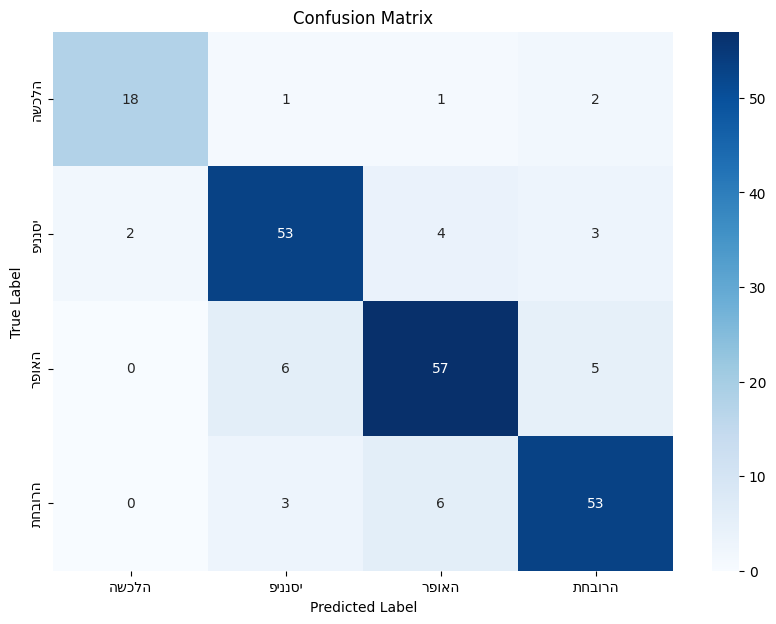

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ביצוע תחזיות על קבוצת ההערכה
predictions = trainer.predict(val_dataset)

# המרת לוגיטים לקטגוריות (בחירת התווית עם ההסתברות הגבוהה ביותר)
preds = np.argmax(predictions.predictions, axis=1)

# חישוב מטריצת הבלבול
conf_matrix = confusion_matrix(val_labels, preds)

# הדפסת מטריצת הבלבול
print("Confusion Matrix:\n", conf_matrix)

# הצגת דוח ביצועים
print("\nClassification Report:\n", classification_report(val_labels, preds, target_names=category_mapping.values()))

# ויזואליזציה של מטריצת הבלבול
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import json

# 1. טעינת המודל וה-Tokenizer
model = BertForSequenceClassification.from_pretrained('./saved_model')
tokenizer = BertTokenizer.from_pretrained('./saved_model')

# 2. טעינת מיפוי הקטגוריות
with open('./saved_model/category_mapping.json', 'r') as f:
    category_mapping = json.load(f)
print("Category Mapping:", category_mapping)  # הדפסת המיפוי בין המספרים לקטגוריות

# 3. פונקציה לניבוי טקסטים
def predict_with_labels(texts):
    # המרת הטקסטים לפורמט שמתאים למודל
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חיזוי הקטגוריה
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    # פענוח המספרים לקטגוריות המקוריות
    predicted_labels = [category_mapping[str(pred.item())] for pred in predictions]
    return predicted_labels

# 4. דוגמה לשימוש
texts_to_predict = [
    """לכבוד,
    מר דוד כהן
    ת.ז. 123456789
    כתובת: רחוב המגנים 34, תל אביב

    נושא: אישור יתרה בחשבון

    אנו מאשרים כי יתרת החשבון שלכם, חשבון מספר 123-456789-0, נכון ל-15 בנובמבר 2024, עומדת על סך 15,350 ש"ח.
    לפרטים נוספים או עדכונים שוטפים, אנא פנו לסניף שלכם או לחצו על הקישור באתר הבנק.

    בברכה,
    בנק תל אביב, סניף 1010
    טלפון: 03-1234567
    אתר: www.banktelaviv.co.il"""
]

texts_to_predict.append(
    """לכבוד,
    מר עידן כהן
    ת.ז. 112233445
    כתובת: רחוב הארזים 88, באר שבע

    נושא: התראה על משיכת יתר

    ברצוננו להודיעך כי יתרת חשבונך, חשבון מספר 789-123456-0, נמצאת במצב משיכת יתר בסך של 2,500 ש"ח.
    מומלץ לבצע הפקדה בהקדם האפשרי על מנת להימנע מעמלות נוספות.

    בברכה,
    בנק הדרום, סניף 303
    טלפון: 08-7654321
    אתר: www.bankdarom.co.il"""
)

texts_to_predict.append(
    """לכבוד,
    גב' רונית שמעוני
    ת.ז. 556677889
    כתובת: רחוב התמרים 76, אשקלון

    נושא: אישור חידוש רישיון רכב

    ברצוננו להודיעך כי רישיון הרכב שלך, מספר רכב 12-345-67, חודש בהצלחה בתאריך 14 בנובמבר 2024.
    התשלום עבור החידוש בסך 1,200 ש"ח התקבל ונרשם במערכת. האישור יישלח אליך בדואר בימים הקרובים.

    בברכה,
    משרד התחבורה
    טלפון: 1-800-123456
    אתר: www.mot.gov.il"""
)


predictions = predict_with_labels(texts_to_predict)
print("Predictions:", predictions)


Category Mapping: {'0': 'השכלה', '1': 'פיננסי', '2': 'רפואה', '3': 'תחבורה'}
Predictions: ['פיננסי', 'פיננסי', 'תחבורה']
